# Magnetogram Radiative Transfer Testing

This notebook tests Surya-generated magnetograms against the radiative transfer equation using the Milne-Eddington approximation for HMI Fe I 6173.15 Å.

## Set up environment and paths

In [1]:
import os
import sys
from pathlib import Path
import numpy as np

# Set CUDA device (adjust based on your setup)
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

# Append paths for imports
sys.path.append("../../")
sys.path.append("../../Surya")

## Import the test function

In [2]:
from test_magnetogram_rt import test_magnetogram_rt

## Run the test

Configure parameters and run the test. The function will:
- Load Surya-generated magnetograms
- Synthesize Stokes profiles using ME forward model
- Validate consistency with radiative transfer equation
- Generate visualizations and statistics

In [3]:
# # Configuration
# config_path = "./configs/config_magnetogram_test.yaml"
# output_dir = "./magnetogram_rt_test_results"
# n_samples = 1  # Number of samples to test
# device = "cuda"  # Use "cpu" if no GPU available

# # Run the test
# test_magnetogram_rt(
#     config_path=config_path,
#     output_dir=output_dir,
#     n_samples=n_samples,
#     device=device
# )

## Simple Single-Pixel Test

Load one image from Surya, extract Bx, By, Bz for a single pixel, and synthesize Stokes profiles (I, Q, U, V).

In [4]:
# Import utility functions
from magnetogram_utils import (
    load_magnetogram_sample,
    extract_pixel_bxyz,
    synthesize_stokes_single_pixel,
    plot_stokes_profiles
)
import yaml
from surya.utils.data import build_scalers

# Load one image from Surya dataset
config_path = "./configs/config_magnetogram_test.yaml"
print("Loading one image from Surya dataset...")
magnetogram_np, velocity_np, dataset = load_magnetogram_sample(config_path, sample_idx=0)

print(f"\nLoaded magnetogram shape: {magnetogram_np.shape}")
print(f"  Bx range: [{magnetogram_np[0].min():.1f}, {magnetogram_np[0].max():.1f}] G")
print(f"  By range: [{magnetogram_np[1].min():.1f}, {magnetogram_np[1].max():.1f}] G")
print(f"  Bz range: [{magnetogram_np[2].min():.1f}, {magnetogram_np[2].max():.1f}] G")

if velocity_np is not None:
    print(f"  Velocity range: [{velocity_np.min():.1f}, {velocity_np.max():.1f}] m/s")
else:
    print("  Velocity: Not available")

# Verify inverse transform: compare normalized vs inverse-transformed
print("\n" + "="*60)
print("Verifying inverse transform...")
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
sample = dataset[0]
ts_normalized = sample['ts']  # [C, T, H, W] - normalized
ts_slice_normalized = ts_normalized[:, -1, :, :]  # [C, H, W] - last time step

# Get channel indices
if dataset.channels is not None:
    hmi_bx_idx = dataset.channels.index('hmi_bx')
    hmi_by_idx = dataset.channels.index('hmi_by')
    hmi_bz_idx = dataset.channels.index('hmi_bz')
else:
    hmi_bx_idx, hmi_by_idx, hmi_bz_idx = 9, 10, 11

# Check normalized values
bx_norm = ts_slice_normalized[hmi_bx_idx]
by_norm = ts_slice_normalized[hmi_by_idx]
bz_norm = ts_slice_normalized[hmi_bz_idx]

print(f"\nNormalized values (before inverse transform):")
print(f"  Bx: min={bx_norm.min():.4f}, max={bx_norm.max():.4f}, mean={bx_norm.mean():.4f}")
print(f"  By: min={by_norm.min():.4f}, max={by_norm.max():.4f}, mean={by_norm.mean():.4f}")
print(f"  Bz: min={bz_norm.min():.4f}, max={bz_norm.max():.4f}, mean={bz_norm.mean():.4f}")

print(f"\nInverse-transformed values (after inverse transform):")
print(f"  Bx: min={magnetogram_np[0].min():.1f}, max={magnetogram_np[0].max():.1f}, mean={magnetogram_np[0].mean():.1f}")
print(f"  By: min={magnetogram_np[1].min():.1f}, max={magnetogram_np[1].max():.1f}, mean={magnetogram_np[1].mean():.1f}")
print(f"  Bz: min={magnetogram_np[2].min():.1f}, max={magnetogram_np[2].max():.1f}, mean={magnetogram_np[2].mean():.1f}")

# Check if values are significantly different (inverse transform should change them)
if abs(bx_norm.min() - magnetogram_np[0].min()) > 1.0:
    print("\n✓ Inverse transform appears to be working (values changed significantly)")
else:
    print("\n⚠ Warning: Inverse transform may not be working (values are too similar)")
print("="*60)

Loading one image from Surya dataset...

Loaded magnetogram shape: (3, 4096, 4096)
  Bx range: [-1404.5, 1751.1] G
  By range: [-1687.0, 1060.4] G
  Bz range: [-1128.6, 1019.6] G
  Velocity range: [-1595.7, 5836.0] m/s

Verifying inverse transform...

Normalized values (before inverse transform):
  Bx: min=-7.9912, max=8.5961, mean=-0.0012
  By: min=-8.5675, max=7.2797, mean=-0.0174
  Bz: min=-25.5402, max=24.5940, mean=0.0035

Inverse-transformed values (after inverse transform):
  Bx: min=-1404.5, max=1751.1, mean=0.1
  By: min=-1687.0, max=1060.4, mean=-0.8
  Bz: min=-1128.6, max=1019.6, mean=0.0

✓ Inverse transform appears to be working (values changed significantly)


In [5]:
# Extract one pixel (center pixel by default, or use max field pixel)
# Set use_max_field=True to use the pixel with strongest field
Bx_pixel, By_pixel, Bz_pixel, B_mag_pixel, velocity_pixel, pixel_h, pixel_w = extract_pixel_bxyz(
    magnetogram_np, 
    velocity_np=velocity_np,  # Pass velocity data
    use_max_field=True  # Set to True to use pixel with maximum field
)

print(f"\nSelected pixel at ({pixel_h}, {pixel_w}):")
print(f"  Bx = {Bx_pixel:.1f} G")
print(f"  By = {By_pixel:.1f} G")
print(f"  Bz = {Bz_pixel:.1f} G")
print(f"  |B| = {B_mag_pixel:.1f} G")
if velocity_pixel is not None:
    from magnetogram_utils import velocity_to_lambda0
    lambda0_from_velocity = velocity_to_lambda0(velocity_pixel)
    print(f"  Velocity = {velocity_pixel:.1f} m/s")
    print(f"  lambda0 (from velocity) = {lambda0_from_velocity:.6f} Å")
else:
    print(f"  Velocity = Not available")


Selected pixel at (2739, 632):
  Bx = 1698.4 G
  By = -1187.8 G
  Bz = -611.2 G
  |B| = 2160.8 G
  Velocity = 250.2 m/s
  lambda0 (from velocity) = 0.005151 Å


In [6]:
# Synthesize Stokes profiles with constant ME parameters
# lambda0 will be computed from velocity if available, otherwise use default (0.0)
stokes_pred, wavelengths, me_params = synthesize_stokes_single_pixel(
    Bx_pixel, By_pixel, Bz_pixel,
    lambda_rest=6173.15,  # HMI Fe I line
    geff=2.5,  # Effective Landé factor
    eta0=2.0,  # Line-to-continuum opacity ratio
    dlambdaD=0.15,  # Doppler width (Angstroms)
    a=0.1,  # Damping parameter
    velocity=velocity_pixel,  # Use velocity from data to compute lambda0
    B0=1.0,  # Continuum source function
    B1=0.5,  # Line source function
    device='cuda'
)

print(f"\nME Parameters used:")
for key, value in me_params.items():
    if key in ['theta', 'chi']:
        print(f"  {key} = {value:.3f} rad ({np.degrees(value):.1f}°)")
    else:
        print(f"  {key} = {value}")

print(f"\nSynthesized Stokes profiles:")
print(f"  I: min={stokes_pred[0].min():.4f}, max={stokes_pred[0].max():.4f}, mean={stokes_pred[0].mean():.4f}")
print(f"  Q: min={stokes_pred[1].min():.4f}, max={stokes_pred[1].max():.4f}, mean={stokes_pred[1].mean():.4f}")
print(f"  U: min={stokes_pred[2].min():.4f}, max={stokes_pred[2].max():.4f}, mean={stokes_pred[2].mean():.4f}")
print(f"  V: min={stokes_pred[3].min():.4f}, max={stokes_pred[3].max():.4f}, mean={stokes_pred[3].mean():.4f}")


ME Parameters used:
  B = 2160.7977154214313
  theta = 1.858 rad (106.4°)
  chi = 2.531 rad (145.0°)
  eta0 = 2.0
  dlambdaD = 0.15
  a = 0.1
  lambda0 = 0.005151014151995203
  B0 = 1.0
  B1 = 0.5
  velocity = 250.1535186767578
  lambda0_source = velocity

Synthesized Stokes profiles:
  I: min=1.2727, max=1.4963, mean=1.4082
  Q: min=-0.0088, max=0.0060, mean=0.0005
  U: min=-0.0191, max=0.0190, mean=-0.0038
  V: min=-0.0270, max=0.0269, mean=-0.0000


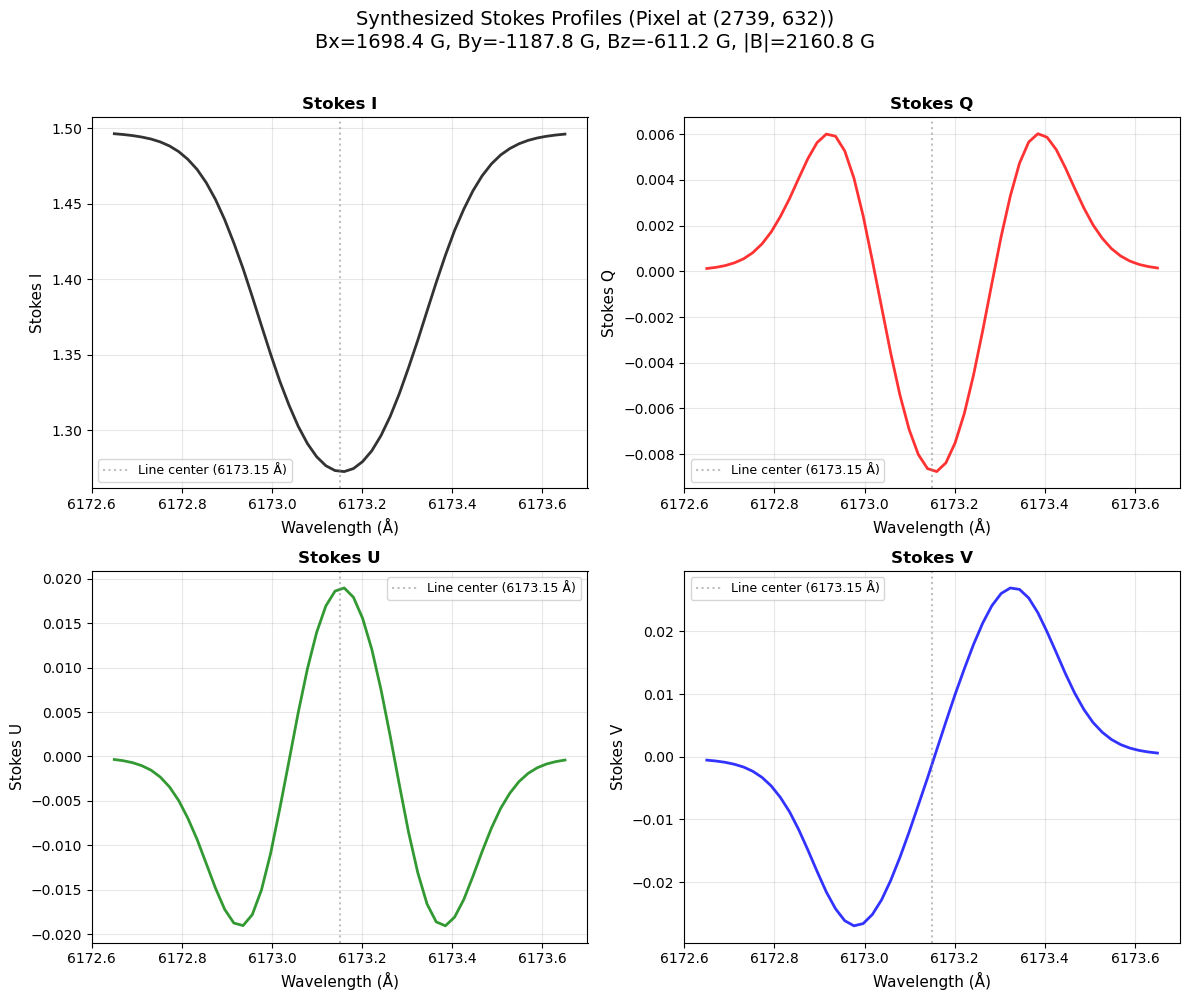

In [7]:
# Plot the synthesized Stokes profiles
plot_stokes_profiles(
    stokes_pred, 
    wavelengths, 
    Bx_pixel, By_pixel, Bz_pixel, B_mag_pixel,
    pixel_h=pixel_h, 
    pixel_w=pixel_w,
    lambda_rest=6173.15
)